In [2]:
# %load modeling_final.py
#!/usr/bin/env python3
"""
Created on Fri Sep  3 09:41:17 2021

@author: XINYUEWU
"""

# In[]
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
import pyfolio as pf

# In[]
path = '/Users/XINYUEWU/Desktop/工作/实习/2021 UCLA sumzero/cleaned data'
os.chdir(path)
ideas = pd.read_csv('ideas_and_ideasupdates.csv')
comments_likes = pd.read_csv('comments_and_likes.csv')


In [20]:
# In[]
#sentiment analysis
def analize_sentiment(text):
    analysis = TextBlob(text)
    result = analysis.sentiment.polarity
    return result

# get ticker return
def get_ticker_return(ticker):
    get_ticker = yf.Ticker(ticker)
    hist = get_ticker.history(start = start_date,end = end_date, interval = yf_rolling_intervals)
    pct_change = hist['Close'].pct_change().fillna(0).astype('float')
    
    #set datetime index
    pct_change.index = pd.DatetimeIndex(pct_change.index)
    res_temp = pct_change.resample(rolling_intervals).bfill().ewm(com=0.5,min_periods = rolling_period).mean().fillna(0)

    #unit index
    res = pd.DataFrame(res_temp,
        index = pd.date_range(
            start = next_start_date, 
            end = next_end_date,
            freq=frequency)).fillna(0)
    
    return res

# get ticker volume
def get_ticker_volume(ticker):
    get_ticker = yf.Ticker(ticker)
    hist = get_ticker.history(start = start_date,end = end_date, interval = yf_rolling_intervals)
    market_cap = hist['Volume'].fillna(0).astype('float')
    
    #set datetime index
    market_cap.index = pd.DatetimeIndex(market_cap.index)
    res_temp = market_cap.resample(rolling_intervals).bfill().ewm(com=0.5,min_periods = rolling_period).mean().fillna(0)

    #unit index
    res = pd.DataFrame(res_temp,
        index = pd.date_range(
            start = next_start_date, 
            end = next_end_date,
            freq=frequency)).fillna(0)
    
    return res

#get one stock's ideas
def get_stock_ideas(ticker_list_index):
    stock_ideas = ideas[ideas['ticker'] == ticker_list[ticker_list_index]].set_index('ideas_id')

    # ideas & ideas updates
    #calculate ideas scores
    stock_ideas_score = stock_ideas[stock_ideas['ideasupdates_id'].isnull() == True].groupby('ideas_available')['SA_score_ideas'].mean()
    
    stock_updates_score = stock_ideas[stock_ideas['ideasupdates_id'].isnull() == False].groupby('ideas_available')['SA_score_updates'].mean()
    
    stock_score = pd.concat([stock_ideas_score,stock_updates_score], axis = 0).groupby(level = 0).mean()
    
    #calculate ideas nums
    stock_ideas_nums = stock_ideas[stock_ideas['ideasupdates_id'].isnull() == True].groupby('ideas_available')['ticker'].count()
    
    stock_updates_nums = stock_ideas[stock_ideas['ideasupdates_id'].isnull() == False].groupby('ideas_available')['ticker'].count()
    
    stock_nums = pd.concat([stock_ideas_nums,stock_updates_nums], axis = 0).groupby(level = 0).mean()
    
    #set datetime index
    stock_score.index = pd.DatetimeIndex(stock_score.index)
    stock_nums.index = pd.DatetimeIndex(stock_nums.index)
    
    #rolling windows
    stock_score_rw = stock_score.resample(rolling_intervals).bfill().ewm(com=0.5,min_periods = rolling_period).mean().fillna(method = 'backfill')
    
    stock_nums_rw = stock_nums.resample(rolling_intervals).bfill().rolling(window = rolling_period).sum().fillna(method = 'backfill')
    
    #calculate factor
    factor_ideas = stock_score_rw*np.log(stock_nums_rw+1).fillna(method = 'bfill')
    factor_ideas = factor_ideas.loc[start_date:end_date].fillna(0).astype('float')
    
    #unit index
    res = pd.DataFrame(factor_ideas,columns = [ticker_list[ticker_list_index]],index = pd.date_range(start=start_date, end=end_date,freq=frequency)).fillna(0)
    
    #return results
    return res

#get one stock's comments    
def get_stock_comments(ticker_list_index):
    ## comments
    stock_ideas = ideas[ideas['ticker'] == ticker_list[ticker_list_index]].set_index('ideas_id')
    stock_comments = comments_likes.loc[comments_likes.index.intersection(stock_ideas.index)]
    
    #calculate comments scores
    stock_comments_score = stock_comments.groupby('comments_created').mean()['SA_score']
    
    stock_comments_nums = stock_comments.groupby('comments_created')['comments_id'].count()
    
    #set datetime index
    stock_comments_score.index = pd.DatetimeIndex(stock_comments_score.index)
    stock_comments_nums.index = pd.DatetimeIndex(stock_comments_score.index)
    
    #rolling windows
    comments_score_rw = stock_comments_score.resample(rolling_intervals).bfill().ewm(com=0.5,min_periods = rolling_period).mean().fillna(method = 'backfill')
    
    comments_nums_rw = stock_comments_nums.resample(rolling_intervals).bfill().rolling(window = rolling_period).sum().fillna(method = 'backfill')
    
    #calculate factor
    factor_comments = comments_score_rw*np.log(comments_nums_rw+1).fillna(method = 'bfill')
    factor_comments = factor_comments.loc[start_date:end_date].fillna(0).astype('float')

   #unit index
    res = pd.DataFrame(factor_comments,columns = [ticker_list[ticker_list_index]],index = pd.date_range(start=start_date, end=end_date,freq=frequency)).fillna(0)
    
    #return results
    return res

#calculate one stock's alpha
def calculate_stock_alpha(data,i):
    X = data.iloc[:,i].diff()
    y = return_sum.iloc[:,i].fillna(0)
        
    model = LinearRegression()
    model.fit(np.array(X).reshape(len(X),1),np.array(y).reshape(len(y),1))
    
    #alpha = model.coef_[0][0]
    alpha = model.intercept_[0]
    #print('ticker name is {},the alpha is {}:'.format(ticker_list[i],alpha))
    
    res = [ticker_list[i],alpha]
    return res

In [4]:
# In[]
#calculate sentiment scores for ideas
ideas['SA_score_ideas'] = ideas['ideas_body'].apply(analize_sentiment)
ideas['SA_score_updates'] = ideas['ideasupdates_body'].fillna(' ').apply(analize_sentiment)

#calculate sentiment scores for comments
comments_likes['SA_score'] = comments_likes['comments_body'].apply(analize_sentiment)
comments_likes = comments_likes.set_index('ideas_id')


In [5]:
# In[]
#setting params
rolling_period = 90
rolling_intervals = 'd'
yf_rolling_intervals = '1d'
frequency = 'D'
start_date = '2016-08-31'
end_date = '2021-07-31'
next_start_date = '2016-09-01'
next_end_date = '2021-08-01'
ticker_list_nums = 20
backtest_date = '2020-08-01'

In [6]:
# In[]
#setting ticker list
ticker_list_full = ideas.groupby('ticker')['ideas_id'].count().sort_values(ascending = False)
ticker_list = ticker_list_full[ticker_list_full >= ticker_list_nums].index

#calculate factor: ideas 
ideas_sum = pd.DataFrame(columns = ticker_list,index = pd.date_range(start=start_date, end=end_date,freq=frequency))
for i in range(len(ticker_list)):
    ideas_sum.iloc[:,i] = get_stock_ideas(i)

#calculate factor: comments 
comments_sum = pd.DataFrame(columns = ticker_list,index = pd.date_range(start=start_date, end=end_date,freq=frequency))
for i in range(len(ticker_list)):
    comments_sum.iloc[:,i] = get_stock_comments(i)


#get ticker return
return_sum = pd.DataFrame(columns = ticker_list,index = pd.date_range(start=next_start_date, end=next_end_date,freq=frequency))
for i in range(len(ticker_list)):
    return_sum.iloc[:,i] = get_ticker_return(ticker_list[i])
    
#get ticker volume
volume_sum = pd.DataFrame(columns = ticker_list,index = pd.date_range(start=next_start_date, end=next_end_date,freq=frequency))
for i in range(len(ticker_list)):
    volume_sum.iloc[:,i] = get_ticker_volume(ticker_list[i])


- AGN: No data found, symbol may be delisted
- 9999996D: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- 9999996D: No data found, symbol may be delisted


In [21]:
# In[]
#strategy one: select stock by ideas
##calculate alpha
ideas_alpha = pd.DataFrame(columns = ['ticker','alpha'],index = range(len(ideas_sum)))
for i in range(len(ticker_list)):
    ideas_alpha.iloc[i,:] = calculate_stock_alpha(ideas_sum,i)

##pick stocks that its alpha >0
ideas_selectedstock = ideas_alpha[ideas_alpha['alpha'] > 0]['ticker']

#strategy two: select stock by comments
##calculate alpha
comments_alpha = pd.DataFrame(columns = ['ticker','alpha'],index = range(len(comments_sum)))
for i in range(len(ticker_list)):
    comments_alpha.iloc[i,:] = calculate_stock_alpha(comments_sum,i)
    
##pick stocks that its alpha > 0
comments_selectedstock = comments_alpha[comments_alpha['alpha'] > 0]['ticker']

The return of portfolio(equal weighted) are: 2.24%
The return of portfolio(weighted by volume) are: 3.89%
The probability of portfolio winning the S&P 500 is: 57.24%
The probability of portfolio winning the S&P 500 is: 58.63%


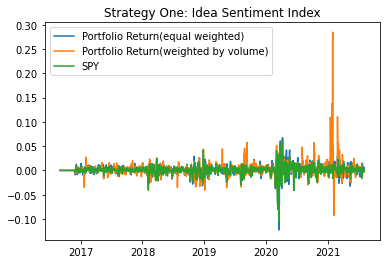

In [22]:
# In[]
#strategy one: select stock by ideas
#calculate portfolio return(equal weighted)
ideas_return_1 = return_sum[ideas_selectedstock].sum(axis = 1)/len(ideas_selectedstock)
print('The return of portfolio(equal weighted) are: {}%'.format(np.round(ideas_return_1.sum(),2)))

#calculate portfolio return(weighted by volume)
weight = volume_sum[ideas_selectedstock].div(volume_sum.sum(axis = 1),axis = 0).fillna(0)
ideas_return_2 = (weight*return_sum[ideas_selectedstock]).sum(axis = 1)
print('The return of portfolio(weighted by volume) are: {}%'.format(np.round(ideas_return_2.sum(),2)))

#plot return and s&p500
plt.plot(ideas_return_1)
plt.plot(ideas_return_2)
plt.plot(get_ticker_return('SPY'))
plt.legend(['Portfolio Return(equal weighted)','Portfolio Return(weighted by volume)','SPY'])
plt.title('Strategy One: Idea Sentiment Index')
plt.savefig('Strategy One: Idea Sentiment Index.png') 
#calculate winning probability
ideas_win_1 = ideas_return_1-get_ticker_return('SPY')['Close']
ideas_prob_1 = np.round((ideas_win_1[ideas_win_1 >= 0].count()/len(ideas_return_1))*100,2)
print('The probability of portfolio winning the S&P 500 is: {}%'.format(ideas_prob_1))

ideas_win_2 = ideas_return_2-get_ticker_return('SPY')['Close']
ideas_prob_2 = np.round((ideas_win_2[ideas_win_2 >= 0].count()/len(ideas_return_2))*100,2)
print('The probability of portfolio winning the S&P 500 is: {}%'.format(ideas_prob_2))


The return of portfolio are: 2.59%
The return of portfolio are: 3.84%
The probability of portfolio winning the S&P 500 is: 58.3%
The probability of portfolio winning the S&P 500 is: 57.96%


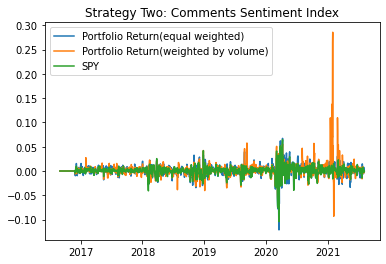

In [23]:
#strategy two: select stock by comments
#calculate portfolio return(equal weighted)
comments_return_1 = return_sum[comments_selectedstock].sum(axis = 1)/len(comments_selectedstock)
print('The return of portfolio are: {}%'.format(np.round(comments_return_1.sum(),2)))

#calculate portfolio return(weighted by volume)
comments_return_2 = (weight*return_sum[comments_selectedstock]).sum(axis = 1)
print('The return of portfolio are: {}%'.format(np.round(comments_return_2.sum(),2)))

#plot return and s&p500
plt.plot(comments_return_1)
plt.plot(comments_return_2)
plt.plot(get_ticker_return('SPY'))
plt.legend(['Portfolio Return(equal weighted)','Portfolio Return(weighted by volume)','SPY'])
plt.title('Strategy Two: Comments Sentiment Index')
plt.savefig('Strategy Two: Comments Sentiment Index') 
#calculate winning probability
comments_win_1 = comments_return_1-get_ticker_return('SPY')['Close']
comments_prob_1 = np.round((comments_win_1[comments_win_1 >= 0].count()/len(comments_return_1))*100,2)
print('The probability of portfolio winning the S&P 500 is: {}%'.format(comments_prob_1))

comments_win_2 = comments_return_2-get_ticker_return('SPY')['Close']
comments_prob_2 = np.round((comments_win_2[comments_win_2 >= 0].count()/len(comments_return_2))*100,2)
print('The probability of portfolio winning the S&P 500 is: {}%'.format(comments_prob_2))

In [24]:
bench = get_ticker_return('SPY')['Close'].tz_localize('UTC')
ideas_return_1 = ideas_return_1.tz_localize('UTC')
ideas_return_2 = ideas_return_2.tz_localize('UTC')
comments_return_1 = comments_return_1.tz_localize('UTC')
comments_return_2 = comments_return_2.tz_localize('UTC')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55.90,2020-02-20,2020-03-17,2020-06-21,87
1,40.94,2018-01-26,2018-12-23,2019-10-20,451
2,12.31,2021-03-17,2021-05-12,2021-06-06,58
3,9.87,2020-10-13,2020-10-29,2020-11-11,22
4,8.85,2021-07-01,2021-07-18,NaT,NaN


/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


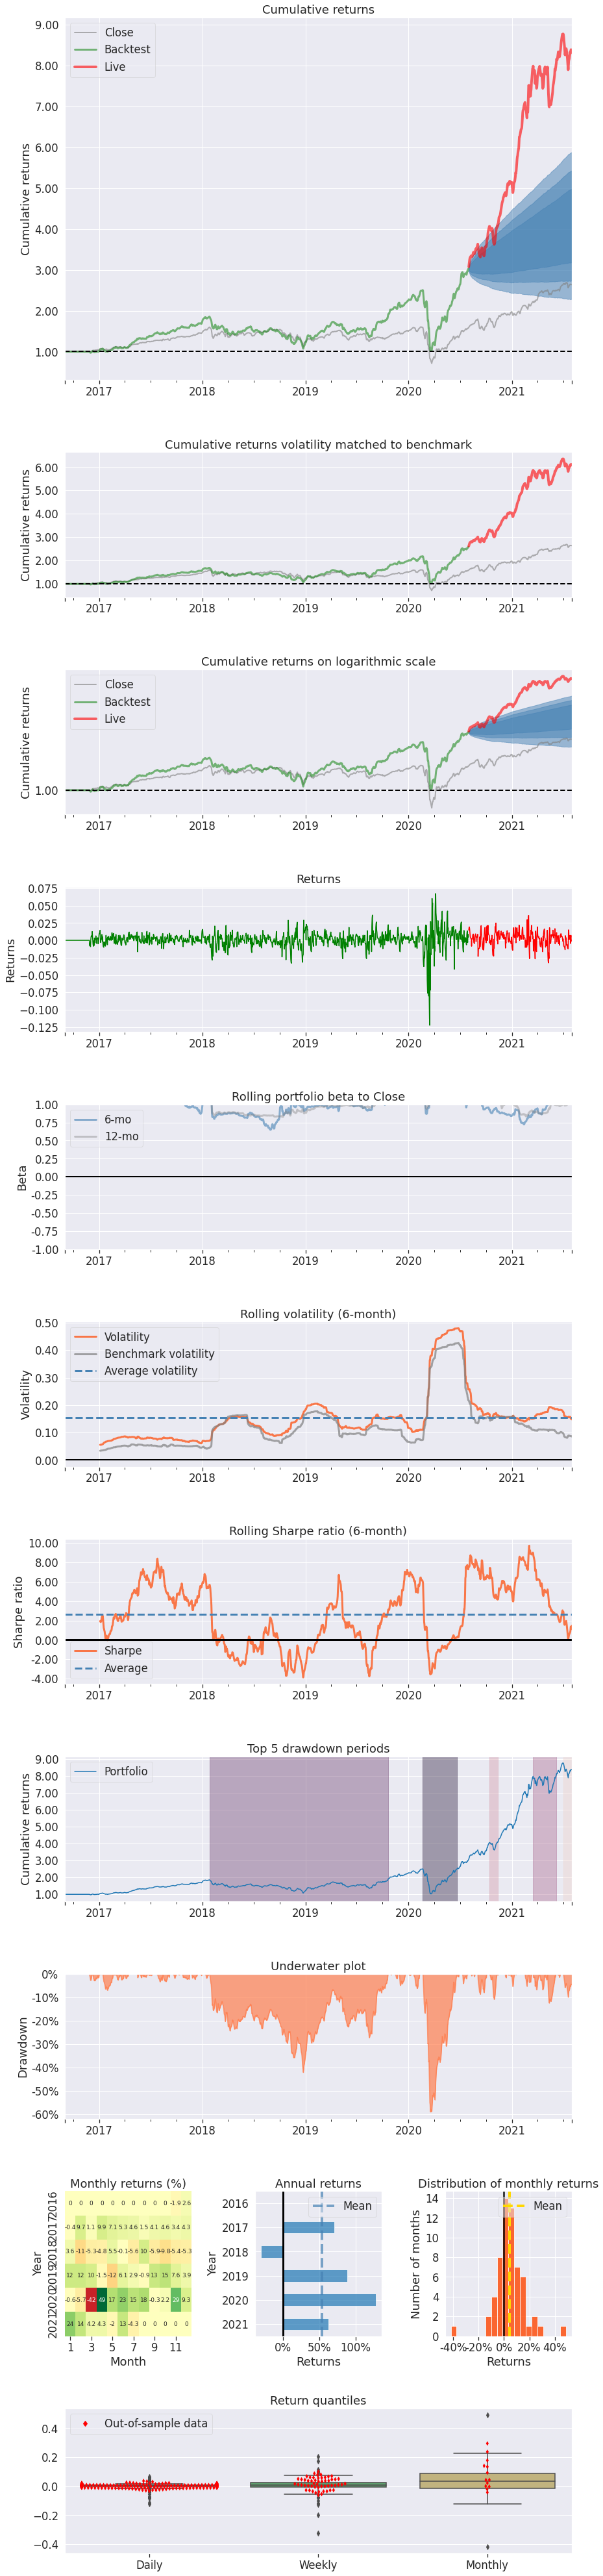

In [25]:
fig_1 = pf.create_returns_tear_sheet(ideas_return_1,benchmark_rets = bench, live_start_date = backtest_date, return_fig=True)
for ax in fig_1.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: Idea Sentiment Index(equal weighted).png') 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.17,2020-01-17,2020-03-22,2020-06-05,101
1,45.74,2018-01-23,2018-12-23,2019-10-15,451
2,25.06,2021-01-29,2021-02-22,2021-03-01,22
3,14.85,2020-09-02,2020-09-10,2020-10-08,27
4,10.44,2020-10-15,2020-10-31,2020-11-16,23


/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 81.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


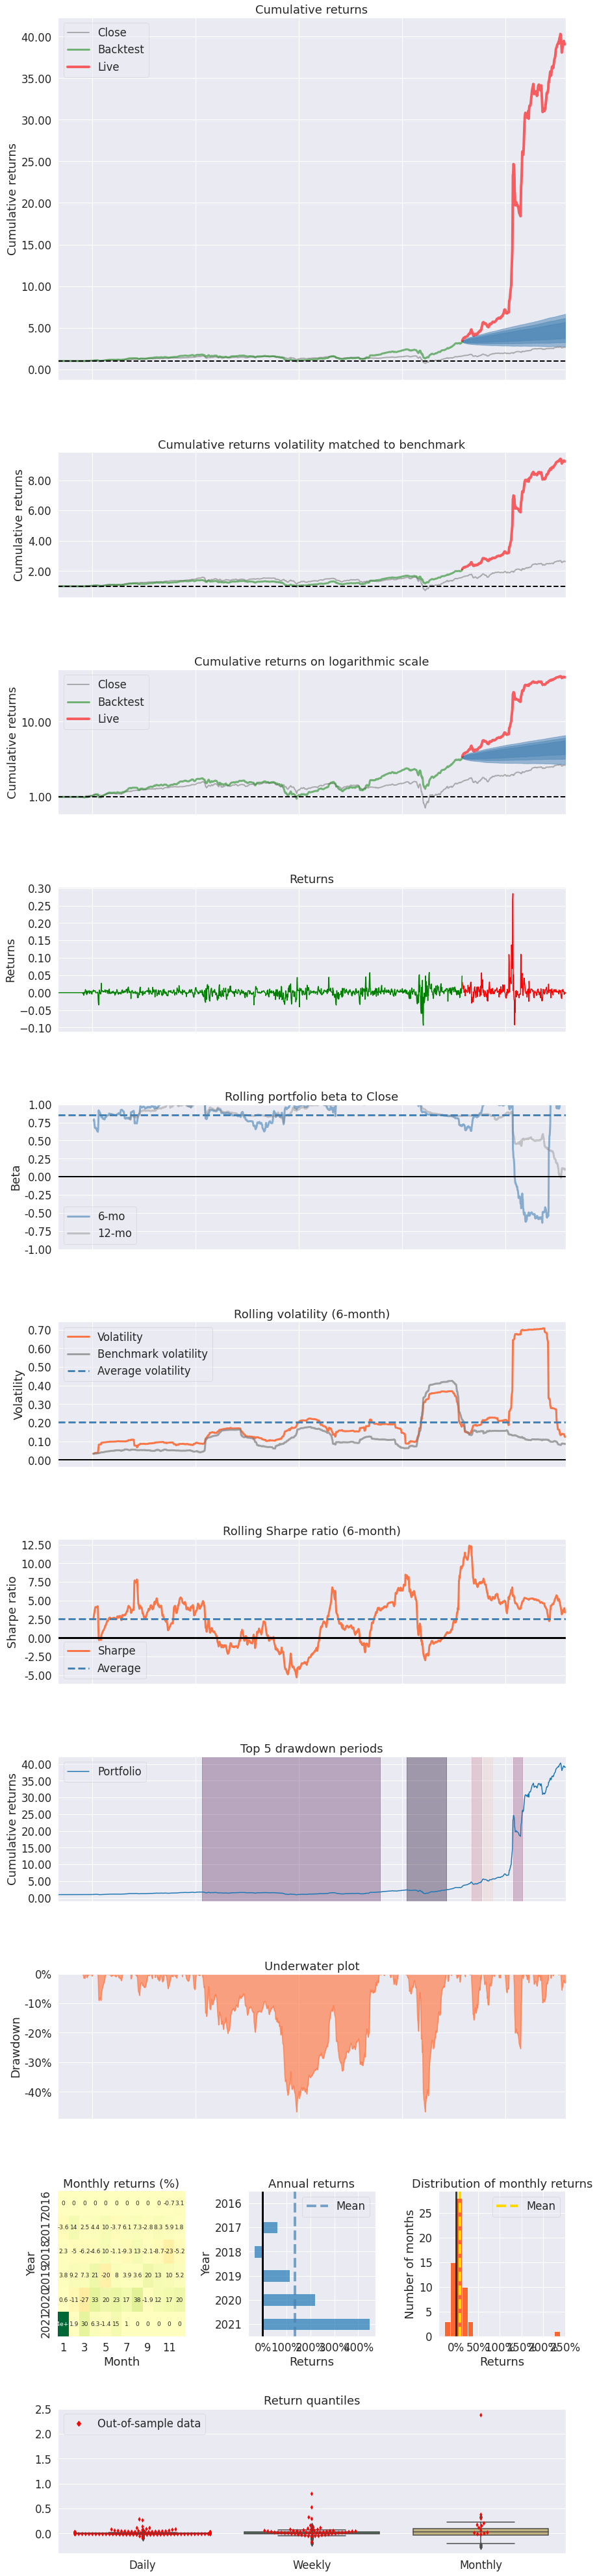

In [43]:
fig_2 = pf.create_returns_tear_sheet(ideas_return_2,benchmark_rets = bench, live_start_date = backtest_date,return_fig=True)
for ax in fig_1.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: Idea Sentiment Index(weight by volume).png') 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,54.21,2020-02-20,2020-03-17,2020-06-07,77
1,40.49,2018-01-12,2018-12-23,2019-10-20,461
2,12.32,2021-04-09,2021-05-12,2021-06-06,41
3,10.22,2020-09-02,2020-09-10,2020-10-04,23
4,9.34,2020-10-13,2020-10-29,2020-11-15,24


/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 72.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


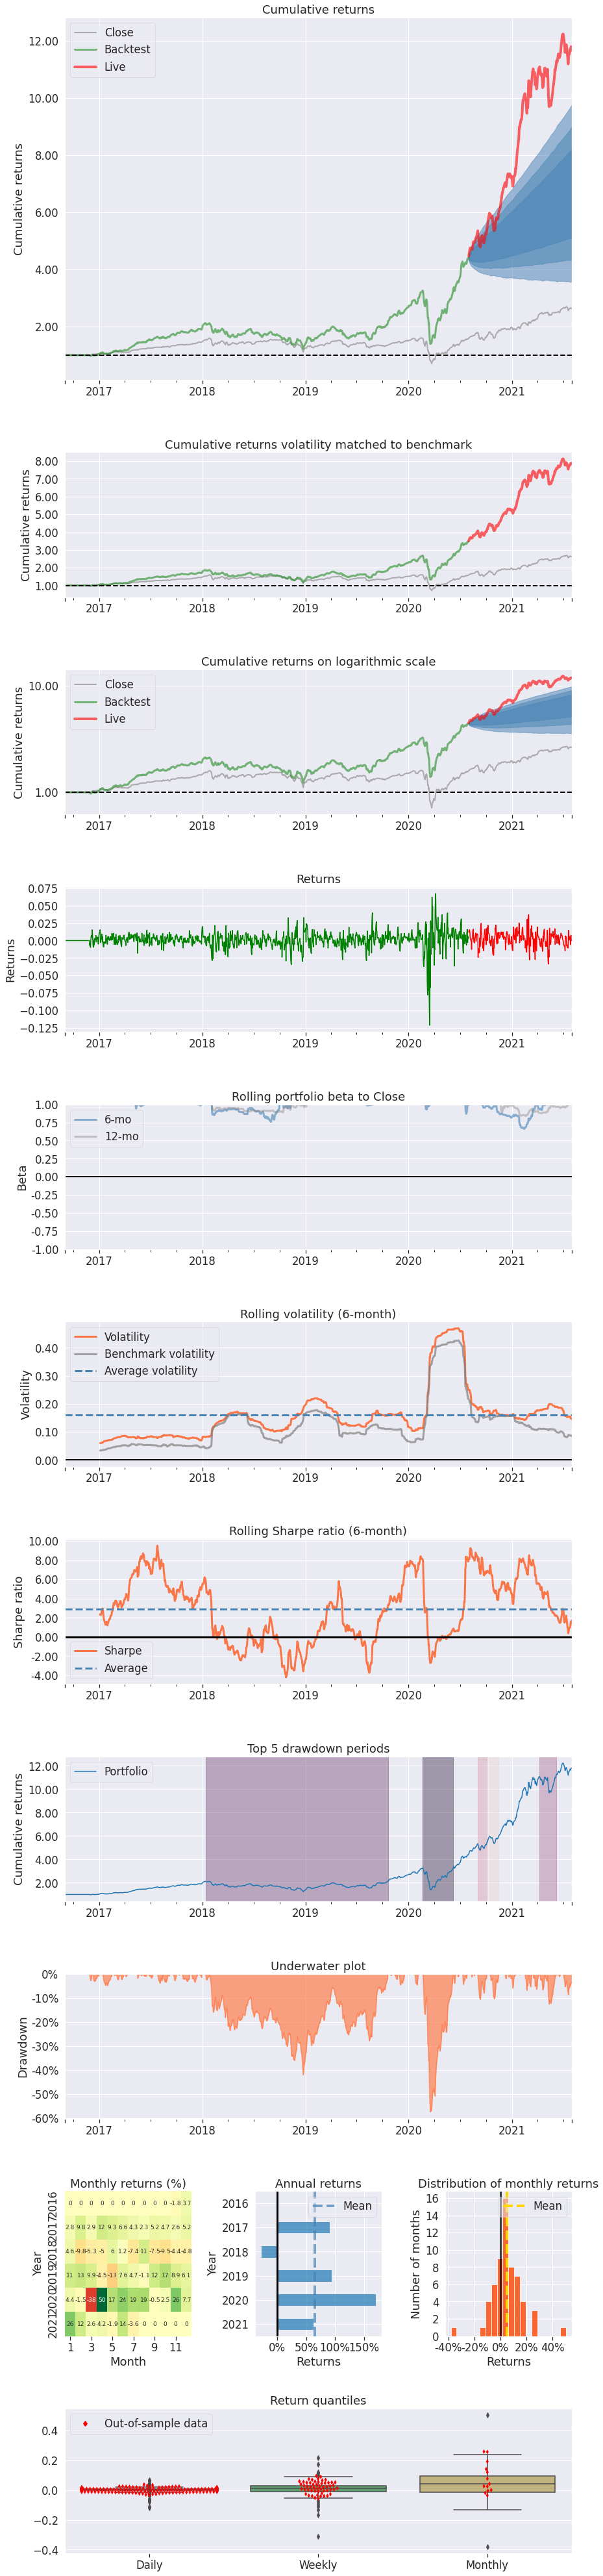

In [44]:
fig_3 = pf.create_returns_tear_sheet(comments_return_1,benchmark_rets = bench, live_start_date = backtest_date,return_fig=True)
for ax in fig_3.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: Comments Sentiment Index(equal weighted).png') 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.23,2018-01-23,2018-12-23,2019-10-21,455
1,43.51,2020-01-17,2020-03-22,2020-06-03,99
2,24.60,2021-01-29,2021-02-22,2021-02-28,21
3,14.40,2020-09-02,2020-09-10,2020-10-08,27
4,10.35,2020-10-15,2020-11-01,2020-11-27,32


/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 81.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


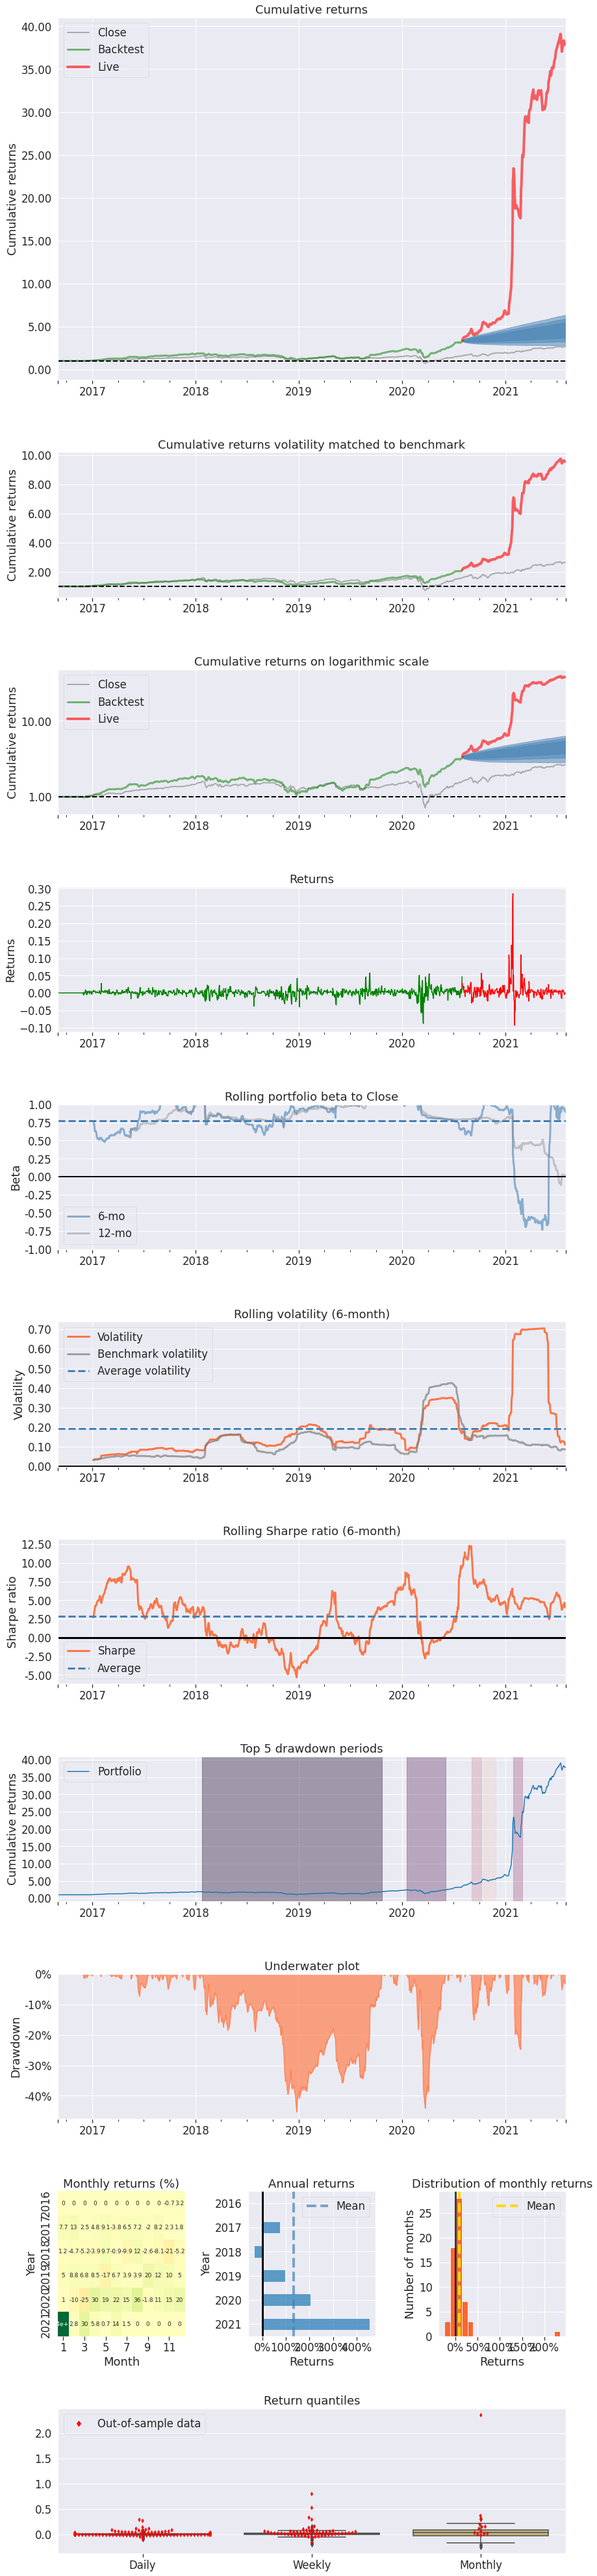

In [45]:
fig_4 = pf.create_returns_tear_sheet(comments_return_2,benchmark_rets = bench, live_start_date =backtest_date,return_fig=True)
for ax in fig_4.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: Comments Sentiment Index(weight by volume).png') 